# XID+PACS ELAIS-S1 Prior

In [1]:
import pylab
import pymoc
import xidplus
import numpy as np
%matplotlib inline
from astropy.table import Table

In [2]:
import seaborn as sns

This notebook uses all the raw data from the XID+PACS catalogue, maps, PSF and relevant MOCs to create XID+ prior object and relevant tiling scheme

## Read in MOCs
The selection functions required are the main MOC associated with the masterlist. As the prior for XID+ is based on IRAC detected sources.

In [3]:
Sel_func=pymoc.MOC()
Sel_func.read('../data/ELAIS-S1/holes_ELAIS-S1_irac1_O16_20180122_MOC.fits')

## Read in XID+MIPS catalogue

In [6]:
XID_MIPS=Table.read('../dmu26_XID+MIPS_ELAIS-S1/data/dmu26_XID+MIPS_ELAIS-S1_20180215.fits')

The uncertianties become Gaussian by $\sim 30 \mathrm{\mu Jy}$

In [7]:
good=XID_MIPS['F_MIPS_24']>30

In [8]:
good.sum()

194276

## Read in Maps

In [10]:
PACS_100='../../dmu18/dmu18_HELP-PACS-maps/data/ELAIS-S1_PACS100_v0.9.fits'
PACS_160='../../dmu18/dmu18_HELP-PACS-maps/data/ELAIS-S1_PACS160_v0.9.fits'
#output folder
output_folder='./'

In [11]:
from astropy.io import fits
from astropy import wcs

#-----100-------------
hdulist = fits.open(PACS_100)
im100phdu=hdulist[0].header
im100hdu=hdulist[1].header
im100=hdulist[1].data
w_100 = wcs.WCS(hdulist[1].header)
pixsize100=3600.0*np.abs(hdulist[1].header['CDELT1']) #pixel size (in arcseconds)
nim100=hdulist[2].data
hdulist.close()

#-----160-------------
hdulist = fits.open(PACS_160)
im160phdu=hdulist[0].header
im160hdu=hdulist[1].header

im160=hdulist[1].data #convert to mJy
w_160 = wcs.WCS(hdulist[1].header)
pixsize160=3600.0*np.abs(hdulist[1].header['CDELT1']) #pixel size (in arcseconds)
nim160=hdulist[2].data
hdulist.close()

## Read in PSF

In [12]:
pacs100_psf=fits.open('../../dmu18/dmu18_ELAIS-S1/dmu18_PACS_100_PSF_ELAIS-S1_20180214.fits')
pacs160_psf=fits.open('../../dmu18/dmu18_ELAIS-S1/dmu18_PACS_160_PSF_ELAIS-S1_20180214.fits')

centre100=np.long((pacs100_psf[1].header['NAXIS1']-1)/2)
radius100=15
centre160=np.long((pacs160_psf[1].header['NAXIS1']-1)/2)
radius160=25

pind100=np.arange(0,radius100+1+radius100,1)*3600*np.abs(pacs100_psf[1].header['CDELT1'])/pixsize100 #get 100 scale in terms of pixel scale of map
pind160=np.arange(0,radius160+1+radius160,1)*3600*np.abs(pacs160_psf[1].header['CDELT1'])/pixsize160 #get 160 scale in terms of pixel scale of map

In [13]:
print(pind100)

[  0.           0.33333333   0.66666667   1.           1.33333333
   1.66666667   2.           2.33333333   2.66666667   3.           3.33333333
   3.66666667   4.           4.33333333   4.66666667   5.           5.33333333
   5.66666667   6.           6.33333333   6.66666667   7.           7.33333333
   7.66666667   8.           8.33333333   8.66666667   9.           9.33333333
   9.66666667  10.        ]


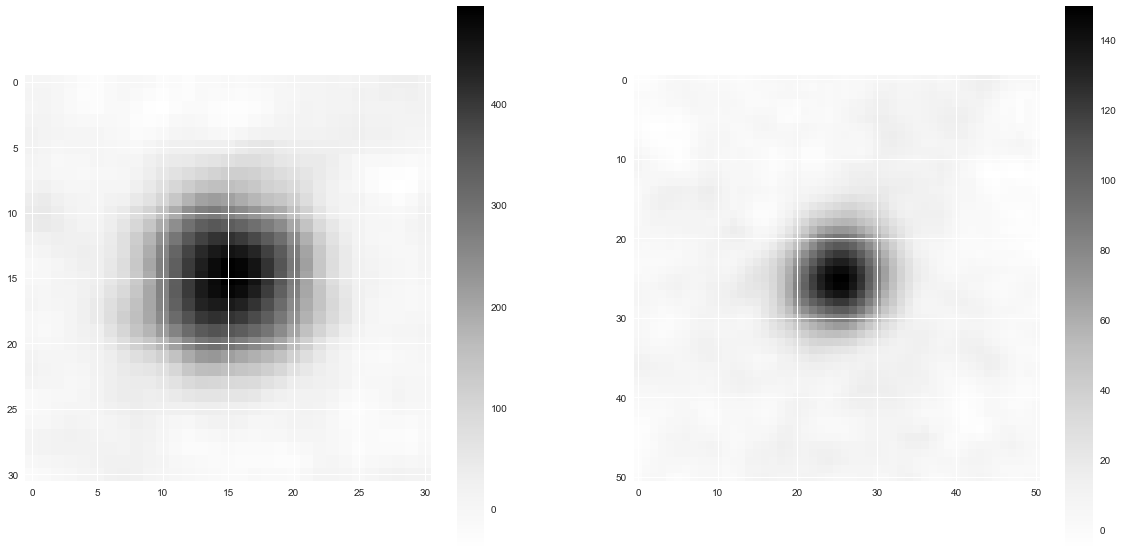

In [14]:
import pylab as plt
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(pacs100_psf[1].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(pacs160_psf[1].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1])
plt.colorbar()

## Set XID+ prior class

In [15]:
#---prior100--------
prior100=xidplus.prior(im100,nim100,im100phdu,im100hdu, moc=Sel_func)#Initialise with map, uncertianty map, wcs info and primary header
prior100.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_ELAIS-S1_20180215.fits',ID=XID_MIPS['help_id'][good])#Set input catalogue
prior100.prior_bkg(0.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)

#---prior160--------
prior160=xidplus.prior(im160,nim160,im160phdu,im160hdu, moc=Sel_func)
prior160.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_ELAIS-S1_20180215.fits',ID=XID_MIPS['help_id'][good])
prior160.prior_bkg(0.0,5)

In [16]:
# Divide by 1000 so that units are mJy
prior100.set_prf(pacs100_psf[1].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1]/1000.0,
                pind100,pind100)
prior160.set_prf(pacs160_psf[1].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1]/1000.0,
                pind160,pind160)

In [17]:
import pickle
#from moc, get healpix pixels at a given order
from xidplus import moc_routines
order=10
tiles=moc_routines.get_HEALPix_pixels(order,prior100.sra,prior100.sdec,unique=True)
order_large=6
tiles_large=moc_routines.get_HEALPix_pixels(order_large,prior100.sra,prior100.sdec,unique=True)
print('----- There are '+str(len(tiles))+' tiles required for input catalogue and '+str(len(tiles_large))+' large tiles')
output_folder='./'
xidplus.io.pickle_dump({'priors':[prior100,prior160],'tiles':tiles,'order':order,'version':xidplus.io.git_version()},'Master_prior.pkl')
outfile=output_folder+'Tiles.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'tiles':tiles,'order':order,'tiles_large':tiles_large,'order_large':order_large,'version':xidplus.io.git_version()},f)
raise SystemExit()

----- There are 2165 tiles required for input catalogue and 18 large tiles
writing total_bytes=781068219...
writing bytes [0, 781068219)... done.


SystemExit: 

In [18]:
ls -ltrh

total 1525656
drwxr-xr-x@ 3 pdh21  pdh21   102B 14 Feb 16:33 data/
-rw-rw-r--  1 pdh21  pdh21    41K 15 Feb 11:16 XID+PACS_prior.ipynb
-rw-rw-r--  1 pdh21  pdh21    18K 15 Feb 11:25 Tiles.pkl
-rw-rw-r--  1 pdh21  pdh21   745M 15 Feb 11:25 Master_prior.pkl
